# Demo RNA Kohonen SOM y LVQ para segmentar datos de TIPOS de Flores IRIS
Basado en  https://github.com/pankajr141/SOM

1) Cargar librerías:

In [1]:
#@title Librerías a usar
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import random
import copy
from scipy.spatial.distance import cdist
import pandas as pd

from sklearn.model_selection import train_test_split
from keras.utils import np_utils

from  sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output

print("Librerías cargadas")

Librerías cargadas


In [2]:
#@title Funciones Auxiliares

# variables auxiliares 
atributo_clase = ""

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# funciones auxiliares
def genTableClusters(rna, x_datos, x_colNames, y_datos, y_colName):
  # diccionario para generar la tabla
  colDict = {}
  # formatea otras columnas
  for i in range(len(x_colNames)):
    colDict[x_colNames[i]] = x_datos[:, i]
  # formatea clase original
  clasesAsign = []
  for d in y_datos:
    clasesAsign.append( CLASES[d] )
  colDict[y_colName] = clasesAsign
  # aplica SOM sobre datos 
  if isinstance(rna, SOM):
    # es SOM
    y_Clust = rna.assignClusters(x_datos)
    colDict["SOM"] = y_Clust  
  else:
    # es LVQ
    y_Clust = rna.assignClusters(x_datos, CLASES)
    colDict["LVQ"] = y_Clust  
  # genera tabla
  auxTable = pd.DataFrame(colDict)
  return auxTable

def genGraph_Scatter(ndf, colx, coly, colz, titulo):
  if colx not in ndf or coly not in ndf or (colz!="" and colz not in ndf):
    if colx not in ndf:
      print("Nombre de columna X '" + colx + "' no existente!!")
    elif coly not in ndf:
      print("Nombre de columna Y '" + coly + "' no existente!!")
    elif (colz!="-" and colz!="" and colz not in ndf):
      print("Nombre de columna Z '" + colz + "' no existente!!")
    return
  else:
    fig = plt.figure(figsize=(15,8)) 
    if colz == "" or colz=="-":
      # gráfico general
      plt.scatter(ndf[colx], ndf[coly])
    else:
      # gráfico marcando colores por valor de colz
      legValues = []
      for val in  ndf[colz].unique():
        auxDF = ndf[ ndf[colz] == val]
        auxDF = auxDF.drop(labels=colz, axis=1) 
        plt.scatter(auxDF[colx], auxDF[coly])
        legValues.append(val)
      plt.legend(legValues, loc='best')
    plt.xlabel(colx)
    plt.ylabel(coly)
    plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
    plt.grid(color='lightgrey', which='major', axis='x', linestyle='solid', linewidth=0.3)
    plt.show()


def generar_estadisticas_detalladas(orDF, titulo=""):
  # título
  print("\n", titulo, ": ") 
  # obtiene las estadísticas generales
  estDF = orDF.describe().transpose()
  #  genera y formatea las estadísticas
  if "min" in estDF and "max" in estDF:
    rangoValores = "[ " + estDF["min"].apply('{:.2f}'.format) + " ; " + estDF["max"].apply('{:.2f}'.format) + " ]"    
  else:
    rangoValores = estDF["unique"].fillna(0.0).apply('{:.0f}'.format)
  rangoValores.name = "Rango Valores"
  # para campos no numéricos muestra las cantidades por valor
  for col in orDF.columns:
    if orDF[col].dtypes in ("object", "bool"):
      auxStr = str( orDF[col].value_counts() ).replace("\n", " ; ")
      if (auxStr.index("Name")-3) > 0:
        # saca lo del final porque no sirve
        auxStr = auxStr[:auxStr.index("Name")-3]
      rangoValores[col] = "{ " + auxStr + " }"
  if "mean" in estDF and "std" in estDF:      
    promValores = estDF["mean"].fillna(0.0).apply('{:.3f}'.format) + " ± " + estDF["std"].fillna(0.0).apply('{:.3f}'.format)
  else:
    promValores = estDF["count"].apply('{:.0f}'.format)
  promValores.name = "Promedio ± Desvío"
  # obtiene valores "ceros" y nulos
  zero_val = (orDF == 0.00).astype(int).sum(axis=0)
  zero_val.name = "¿Valores Ceros?"
  mis_val = orDF.isnull().sum()
  mis_val.name = "¿Valores Nulos?"
  # prepara la nueva tabla para mostrar
  nTable = pd.concat([orDF.dtypes, rangoValores, promValores, zero_val, mis_val], axis=1)
  nTable = nTable.rename( columns = {0: 'Tipo Valor',  1: 'Rango Valores', 2: 'Promedio ± Desvío', 3: '¿Valores Ceros?', 4: '¿Valores Nulos?' } )
  # muestra la nueva tabla
  pd.set_option('max_colwidth', None)
  display(nTable.fillna("-"))
  print("Tiene " + str(orDF.shape[1]) + " atributos y " + str(orDF.shape[0]) + " ejemplos.")
  print("\n")
  return 

def mostrarEstadisticasCusters(df):
  # mostrar nuevas estadísticas por Cluster
  print("> Estadísticas: ")
  atributo_clase = "SOM"
  ndf = df.sort_values(by=list([atributo_clase]))
  for val in  ndf[atributo_clase].fillna("-NAN-").unique():
      auxDF = ndf[ ndf[atributo_clase].fillna("-NAN-") == val]
      auxDF = auxDF.drop(labels=atributo_clase, axis=1) 
      generar_estadisticas_detalladas(auxDF, "-" + str(val) )


# función auxiliar para probar el modelo entrenado en detalle
def probarModeloLVQ(rna, x, y, clases_map):

    # procesa las imágenes de prueba con el modelo 
    predClass = rna.predict(x)

    # muestra los resultados con las imágenes 
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # prepara salida
        clReal = clases_map[ y[i] ] 
        
        # determina clase predecida 
        idclPred =  predClass[i]
        clPred = clases_map[ idclPred ]

        classReal.append( clReal )
        classPreds.append( clPred )

        strTitulo = 'Real: ' + clReal + ' / LVQ: ' 
        strTitulo = strTitulo + clPred + ' (' + str( idclPred ) +')'   
        strTitulo = strTitulo + ": " + ("ok" if (clPred==clReal) else "error!")

        # muestra comparación con la imagen
        print(strTitulo)

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds))

    # muestra matriz de confusion
    print('\nMatriz de Confusión: ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm, 
        index=['r:{:}'.format(x) for x in clases_map], 
        columns=['p:{:}'.format(x) for x in clases_map]
      )
    # agrega para poder mostrar la matrix de confusión completa
    pd.options.display.max_rows = 100
    pd.options.display.max_columns = 100
    print(cmtx)
    print("\n")

    # gráfico de comparación
    plt.title('Gráfico de Confusión:')
    plt.xlabel('Real')
    plt.ylabel('LVQ')
    plt.scatter(classReal, classPreds)

print("Funciones auxiliares definidas")

Funciones auxiliares definidas


2) Cargar los datos:

In [3]:
# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demo ANIMALES'  #@param {type:"string"}


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
## selección de los parámetros 

#@markdown ### Archivo de datos a utilizar:
archivo_datos = '/datos/animales.csv'  #@param {type:"string"}
#@markdown ### Nombre del atributo clase / objetivo:
atributo_clase = 'TIPO' #@param {type:"string"}
#@markdown ### Descripción de los valores del atributo clase / objetivo:  (nota: siempre debe comienzar en 0, por lo que si no tiene valor 0, agregar "na")
nombre_clases = 'na, MAMIFERO, AVE, REPTIL, PEZ, ANFIBIO, INSECTO, INVERTEBRADO' #@param {type:"string"}
#@markdown ### Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   80#@param {type:"integer"}

## aplicación de los parámetros elegidos

# define nombre atributo de CLASE para ejemplo IRIS
ClassAttributeName = atributo_clase

# define valores de clases para ejemplo IRIS
CLASES = [ ]
for val in nombre_clases.split(','):
  CLASES.append( val )

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

print("Configuración definida de ", archivo_datos)
print("Atributo clase: ", ClassAttributeName, ": ", CLASES)

Configuración definida de  /datos/animales.csv
Atributo clase:  TIPO :  ['na', ' MAMIFERO', ' AVE', ' REPTIL', ' PEZ', ' ANFIBIO', ' INSECTO', ' INVERTEBRADO']


In [5]:
#@title Cargar datos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos)
print("\n> Cabecera: ")
print(df.head())
print("\n> Características: ")
print(df.describe())

# genera los datos solo con la clase para entrenar y probar
colNames = list(df.columns)
Y = np.array(df.pop(ClassAttributeName))
colNames.remove(ClassAttributeName)
X = np.array(df)


> Cabecera: 
   TIENE_PELO  TIENE_PLUMAS  PONE_HUEVOS  DA_LECHE  ES_AEREO  ES_ACUATICO  \
0           1             0            0         1         0            0   
1           1             0            0         1         0            0   
2           0             0            1         0         0            1   
3           1             0            0         1         0            0   
4           1             0            0         1         0            0   

   ES_PREDADOR  TIENE_DIENTES  TIENE_COLUMNA  RESPIRA  ES_VENENOSO  \
0            1              1              1        1            0   
1            0              1              1        1            0   
2            1              1              1        0            0   
3            1              1              1        1            0   
4            0              1              1        1            0   

   TIENE_ALETAS  CANT_PATAS  TIENE_COLA  ES_DOMESTICO  TIPO  
0             0           4           0 

In [6]:
#@title Preparar datos

# separa al azar usando muestreo estratificado con proporción indicada
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y)

# muestra resultados
print("> Para Ambos: ")
print(" - dictMapeo: ", CLASES)

print("\n> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
for i in range(len(CLASES)):
  cant = 0
  for y in y_train:
    if i == y: cant = cant + 1
  print("    ", CLASES[i], "[", i, "]:", cant)

print("\n Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
for i in range(len(CLASES)):
  cant = 0
  for y in y_test:
    if i == y: cant = cant + 1
  print("    ", CLASES[i], "[", i, "]:", cant)


> Para Ambos: 
 - dictMapeo:  ['na', ' MAMIFERO', ' AVE', ' REPTIL', ' PEZ', ' ANFIBIO', ' INSECTO', ' INVERTEBRADO']

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (40, 15)
 - y_train (cant):  40
     na [ 0 ]: 0
      MAMIFERO [ 1 ]: 12
      AVE [ 2 ]: 7
      REPTIL [ 3 ]: 4
      PEZ [ 4 ]: 3
      ANFIBIO [ 5 ]: 3
      INSECTO [ 6 ]: 5
      INVERTEBRADO [ 7 ]: 6

 Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (10, 15)
 - y_test (cant):  10
     na [ 0 ]: 0
      MAMIFERO [ 1 ]: 3
      AVE [ 2 ]: 1
      REPTIL [ 3 ]: 1
      PEZ [ 4 ]: 1
      ANFIBIO [ 5 ]: 1
      INSECTO [ 6 ]: 1
      INVERTEBRADO [ 7 ]: 2


3) Procesar con RNA KOHONEN SOM:

In [7]:
#@title Establecer Clase RNA SOM

# clase copiada de https://github.com/pankajr141/SOM/blob/master/somlib/som_numpy.py
# con algunas modificaciones menores
class SOM():
    """
    The numpy based Kohonen self organizing map implementation.
    """
    def __init__(self, neurons, n_iter=500, learning_rate=0.05, mostrarDetalle=True):        
        self.neurons = neurons
        self.initial_learning_rate = learning_rate        
        self.n_iter = n_iter
        self.weights = None
        self.centroides = None
        self.mostrarDetalle_ = mostrarDetalle

    def resetState(self, dimentions):
        neighbourhood_radius = np.sum(self.neurons)
        self.weights = np.random.randint(0, 255, size=(self.neurons[0], self.neurons[1], dimentions)) / 255
        self.learning_rate = self.initial_learning_rate
        self.initial_neighbourhood_radius = neighbourhood_radius
        self.neighbourhood_radius = neighbourhood_radius
        self.time_constant = self.n_iter/np.log(self.initial_neighbourhood_radius)
        if self.mostrarDetalle_:
          print("      Pesos iniciales: ")
          for i in range(self.weights.shape[0]):
            for j in range(self.weights.shape[1]):
              print("             Cluster_"+str(i*self.weights.shape[1]+j+1), ":", self.weights[i,j])
          print("\n")        

    def _updateWeights(self, sample):
        dimentions = self.weights.shape
        
        # Fund BMU neuron
        distances = cdist(self.weights.reshape(dimentions[0]*dimentions[1], dimentions[2]), sample, metric='euclidean')
        distances = distances.reshape(dimentions[0], dimentions[1])
        indices = np.where(distances == distances.min())  # Getting the neuron with min distance
        
        """ Caculate how much each neighbourhood neurons will affect the weight basted on their distance"""
        closestNeuron = self.weights[indices[0][0], indices[1][0]]

        # Calcualte the euclidean distances of neurons from BMU
        distances = cdist(self.weights.reshape(dimentions[0] * dimentions[1], dimentions[2]), 
                          closestNeuron.reshape(1, dimentions[2]), metric='euclidean')
        # Arrange distances as sorted index
        distances = np.argsort(np.argsort(distances.reshape(dimentions[0] * dimentions[1])))
        distances = distances.reshape(dimentions[0], dimentions[1])
        
        # Mark the neurons with distance greater then neighbourhood_radius as with influence 0
        influenceVector = copy.deepcopy(distances)
        influenceVector[distances > self.neighbourhood_radius] = -1
        influenceVector[influenceVector >= 0] = 1
        influenceVector[influenceVector == -1] = 0

        influenceValues =  np.exp(-np.multiply(distances, distances) / (2 * self.neighbourhood_radius * self.neighbourhood_radius))
        influenceValues = np.multiply(influenceVector, influenceValues)
        influenceValues = influenceValues.reshape(self.weights.shape[0], self.weights.shape[1], 1)

        """Update weights using learning rate, influence """
        self.weights = self.weights + np.multiply(influenceValues, (sample - self.weights))  * self.learning_rate

    def _updateLearningRate(self, iteration):
        """Function to update the learning rate"""
        self.learning_rate = self.initial_learning_rate * np.exp(-iteration/self.n_iter)

    def _updateNeighbourhoodRadius(self, iteration):
        """Function to update the neighbourhood radius"""
        self.neighbourhood_radius = self.initial_neighbourhood_radius * np.exp(-iteration/self.time_constant)

    def train(self, data):
        if len(data) == 0:
          print("No hay datos para entrenar!")
          return 
        if self.mostrarDetalle_:
          print("\n *** Comienza el entrenamiento ***")
        # inicializa parámetros del entrenamiento
        self.resetState(len(data[0]))        
        # prepara the data 
        samples = self.prepareData(data)
        # Define Time constant used by learning rate and neighbourhood radius        
        for it in range(1, self.n_iter+1):
            if self.mostrarDetalle_:
              if (it==1) or (it%10)==1 or (it==(self.n_iter)):
                print("     ", it, ": lr =", round(self.learning_rate, 5))
            for _ in samples:
                sample = random.choice(samples)
                """For each sample check which neuron has closest proximity"""
                self._updateWeights(sample)
            self._updateLearningRate(it)
            self._updateNeighbourhoodRadius(it)
        # cambia estructura de los clusters para mostrar centroides
        self.centroides = self.weights.reshape(self.weights.shape[0] * self.weights.shape[1], self.weights.shape[2])
        if self.mostrarDetalle_:
          print("\n *** Entrenamiento finalizado ***")
 
    def assignClusters(self, data):
        if self.centroides is None:
          return []
        # prepara the data 
        samples = self.prepareData(data)
        # predict
        result = []
        for sample in samples:
            distances = cdist(self.centroides, sample, metric='euclidean')
            indices = np.where(distances == distances.min())  # Getting the neuron with min distance
            result.append( "Cluster_"+str(indices[0][0]+1) )
        return np.array(result)

    def prepareData(self, data):
      # determina cantidad de dimensiones a usar
      # fromatea los datos para que se pueda entrenrar
      samples = []
      cantDim = len(data[0])
      for x in data:
        samples.append( x.reshape(1, cantDim) )
      return samples

    def showCentroides(self, colNames):
      # muestra los centroides / pesos de las conexiones
      print("\n\nCluster Centroides: \n")
      colDict = {}      
      for l in range(len(self.centroides)):
        # agrega columna clusters
        cl = "Cluster_"+str(l+1)
        if "SOM" in colDict:
          colDict["SOM"].append( cl )
        else:
          colDict["SOM"] = [ cl ]
        # agrega las otras
        for col, centroide in zip(colNames, self.centroides[l]):
          if col in colDict:
            colDict[col].append( centroide )
          else:
            colDict[col] = [centroide]     
      # genera df auxiliar
      centroidesTable = pd.DataFrame(colDict)
      display( centroidesTable )


print("Clase RNA SOM definida")

Clase RNA SOM definida


In [16]:
#@title Entrenar RNA SOM

SOM_cant_neuronas_salida_n = 3 #@param {type:"integer"}
SOM_cant_neuronas_salida_m =  3#@param {type:"integer"}

SOM_learning_rate_SOM = 0.05 #@param {type:"number"}
SOM_cant_ciclos_entrenamiento_SOM = 500 #@param {type:"integer"}

# controla los parámetros
if SOM_cant_neuronas_salida_n < 1:
  SOM_cant_neuronas_salida_n = 1
if SOM_cant_neuronas_salida_m < 1:
  SOM_cant_neuronas_salida_m = 1
if (SOM_cant_neuronas_salida_n * SOM_cant_neuronas_salida_m) < 2:
  SOM_cant_neuronas_salida_n = 2
  SOM_cant_neuronas_salida_m = 1
if SOM_cant_ciclos_entrenamiento_SOM < 500:
  print("Se debe ciclar por lo menos 500 veces")
  SOM_cant_ciclos_entrenamiento_SOM = 500
if SOM_learning_rate_SOM <= 0:
  SOM_learning_rate_SOM = 0.05


# inicializa la SOM
rnaSOM = SOM(neurons=(SOM_cant_neuronas_salida_n, SOM_cant_neuronas_salida_m), 
             n_iter=SOM_cant_ciclos_entrenamiento_SOM, 
             learning_rate=SOM_learning_rate_SOM)

# manda a entrenar
rnaSOM.train(x_train) 

# muestra centroides
rnaSOM.showCentroides(colNames)


 *** Comienza el entrenamiento ***
      Pesos iniciales: 
             Cluster_1 : [0.93333333 0.24313725 0.58039216 0.6745098  0.89019608 0.10588235
 0.81960784 0.6627451  0.50588235 0.20784314 0.12941176 0.22745098
 0.63529412 0.94117647 0.33333333]
             Cluster_2 : [0.19215686 0.34117647 0.35686275 0.30588235 0.09803922 0.50588235
 0.01176471 0.48235294 0.30196078 0.10980392 0.00392157 0.61176471
 0.65882353 0.41176471 0.78823529]
             Cluster_3 : [0.78039216 0.16862745 0.52941176 0.12941176 0.01960784 0.75294118
 0.18823529 0.70980392 0.22352941 0.14901961 0.04313725 0.65882353
 0.56078431 0.71372549 0.83921569]
             Cluster_4 : [0.22352941 0.85098039 0.94117647 0.95686275 0.50588235 0.55294118
 0.65098039 0.94509804 0.83137255 0.72941176 0.67058824 0.06666667
 0.50980392 0.56862745 0.35686275]
             Cluster_5 : [0.03137255 0.25490196 0.53333333 0.7254902  0.63137255 0.65098039
 0.98431373 0.29019608 0.52156863 0.22352941 0.03921569 0.6
 0.84705882 

,SOM,TIENE_PELO,TIENE_PLUMAS,PONE_HUEVOS,DA_LECHE,ES_AEREO,ES_ACUATICO,ES_PREDADOR,TIENE_DIENTES,TIENE_COLUMNA,RESPIRA,ES_VENENOSO,TIENE_ALETAS,CANT_PATAS,TIENE_COLA,ES_DOMESTICO
0,Cluster_1,0.267538,9.076885e-60,0.923621,7.399687e-48,4.185264e-01,0.400099,0.627466,1.093841e-47,7.625079e-29,0.599901,2.511392e-01,2.221139e-60,6.357085e+00,0.076379,0.080268
1,Cluster_2,0.000270,1.317929e-59,0.999817,1.719137e-04,1.340478e-04,0.999643,0.999741,2.408003e-04,2.846264e-04,0.000465,1.332337e-04,3.659588e-60,5.492943e+00,0.000194,0.000111
2,Cluster_3,0.288715,7.112849e-01,0.711285,2.887151e-01,5.974625e-01,0.320219,0.473383,2.887151e-01,1.000000e+00,1.000000,1.364577e-36,7.328185e-02,2.000000e+00,0.917010,0.217782
3,Cluster_4,0.461141,1.524407e-61,0.669524,4.611410e-01,5.599201e-35,0.518338,0.521596,7.181486e-01,1.000000e+00,1.000000,1.105923e-01,1.530423e-61,4.000000e+00,0.651637,0.211068
4,Cluster_5,0.526060,2.797860e-55,0.850940,4.467237e-44,6.428275e-01,0.123736,0.389563,6.370768e-44,7.805196e-44,0.876264,4.934584e-01,3.029842e-55,6.545591e+00,0.149060,0.156126
5,Cluster_6,0.114172,3.025453e-17,0.741820,1.809372e-01,2.639870e-17,0.446689,0.821191,6.966340e-01,6.966340e-01,0.553399,2.263586e-01,3.694463e-01,1.003397e-16,0.582462,0.056293
6,Cluster_7,0.174725,2.498531e-33,0.606701,2.764400e-01,1.935456e-33,0.676975,0.841507,8.220009e-01,8.220009e-01,0.492886,2.521873e-01,5.601164e-01,2.515360e-20,0.647276,0.087073
7,Cluster_8,0.517346,4.826538e-01,0.482654,5.173462e-01,4.712427e-01,0.298846,0.496062,5.173462e-01,1.000000e+00,1.000000,3.137634e-20,1.314716e-01,2.000000e+00,0.851991,0.238437
8,Cluster_9,0.649388,3.581445e-47,0.436441,6.493878e-01,5.452753e-47,0.338276,0.468496,8.160064e-01,1.000000e+00,1.000000,7.224023e-02,3.364926e-47,4.000000e+00,0.646165,0.359967


In [17]:
#@title Evaluar clusters asignados por RNA SOM {run:"auto"}

SOM_generar_grafico_usar_datos = "entrenamiento" #@param ["entrenamiento", "prueba"]

if SOM_generar_grafico_usar_datos == "entrenamiento":
  xSOM = x_train
  ySOM = y_train
else:
  xSOM = x_test 
  ySOM = y_test 

SOM_mostrar_tabla_completa = False #@param {type:"boolean"}
SOM_mostrar_estadisticas_cluster = True #@param {type:"boolean"}

# genera la tabla con los datos de entrenamiento
dfSOM = genTableClusters(rnaSOM, xSOM, colNames, ySOM, ClassAttributeName)

# muestra la tabla
if SOM_mostrar_tabla_completa:
  print("Resultados de aplicar SOM en datos de " + SOM_generar_grafico_usar_datos + ": ")
  display(dfSOM)
  print("\n")
# mostrar estadísticas
if SOM_mostrar_estadisticas_cluster:
  mostrarEstadisticasCusters(dfSOM)
  print("\n")

# agrega los combos
comboColX = widgets.Dropdown(
    options=colNames,
    value=colNames[0],
    description='Columna X:',
    disabled=False,
)
if len(colNames)>1:
  valYsel = colNames[1]
else:
  valYsel = colNames[0]

comboColY = widgets.Dropdown(
    options=colNames,
    value=valYsel,
    description='Columna Y:',
    disabled=False,
)

comboColZ = widgets.Dropdown(
    options=[ClassAttributeName, "SOM"],
    value="SOM",
    description='Columna Z:',
    disabled=False,
)

ui = widgets.HBox([comboColX, comboColY, comboColZ])

def cambiaSeleccionSOM(x, y, z):
  # genera el gráfico
  genGraph_Scatter(dfSOM, x, y, z, "")

out = widgets.interactive_output(cambiaSeleccionSOM, {'x': comboColX, 'y': comboColY, 'z': comboColZ})
display(ui, out)

> Estadísticas: 

 -Cluster_1 : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
TIENE_PELO,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,3,0
TIENE_PLUMAS,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,3,0
PONE_HUEVOS,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
DA_LECHE,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,3,0
ES_AEREO,int64,[ 0.00 ; 1.00 ],0.333 ± 0.577,2,0
ES_ACUATICO,int64,[ 0.00 ; 1.00 ],0.333 ± 0.577,2,0
ES_PREDADOR,int64,[ 0.00 ; 1.00 ],0.667 ± 0.577,1,0
TIENE_DIENTES,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,3,0
TIENE_COLUMNA,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,3,0
RESPIRA,int64,[ 0.00 ; 1.00 ],0.667 ± 0.577,1,0


Tiene 16 atributos y 3 ejemplos.



 -Cluster_2 : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
TIENE_PELO,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,2,0
TIENE_PLUMAS,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,2,0
PONE_HUEVOS,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
DA_LECHE,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,2,0
ES_AEREO,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,2,0
ES_ACUATICO,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
ES_PREDADOR,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
TIENE_DIENTES,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,2,0
TIENE_COLUMNA,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,2,0
RESPIRA,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,2,0


Tiene 16 atributos y 2 ejemplos.



 -Cluster_3 : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
TIENE_PELO,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,7,0
TIENE_PLUMAS,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
PONE_HUEVOS,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
DA_LECHE,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,7,0
ES_AEREO,int64,[ 0.00 ; 1.00 ],0.714 ± 0.488,2,0
ES_ACUATICO,int64,[ 0.00 ; 1.00 ],0.286 ± 0.488,5,0
ES_PREDADOR,int64,[ 0.00 ; 1.00 ],0.429 ± 0.535,4,0
TIENE_DIENTES,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,7,0
TIENE_COLUMNA,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
RESPIRA,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0


Tiene 16 atributos y 7 ejemplos.



 -Cluster_4 : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
TIENE_PELO,int64,[ 0.00 ; 1.00 ],0.200 ± 0.447,4,0
TIENE_PLUMAS,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,5,0
PONE_HUEVOS,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
DA_LECHE,int64,[ 0.00 ; 1.00 ],0.200 ± 0.447,4,0
ES_AEREO,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,5,0
ES_ACUATICO,int64,[ 0.00 ; 1.00 ],0.800 ± 0.447,1,0
ES_PREDADOR,int64,[ 0.00 ; 1.00 ],0.600 ± 0.548,2,0
TIENE_DIENTES,int64,[ 0.00 ; 1.00 ],0.600 ± 0.548,2,0
TIENE_COLUMNA,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
RESPIRA,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0


Tiene 16 atributos y 5 ejemplos.



 -Cluster_5 : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
TIENE_PELO,int64,[ 0.00 ; 1.00 ],0.750 ± 0.500,1,0
TIENE_PLUMAS,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,4,0
PONE_HUEVOS,int64,[ 0.00 ; 1.00 ],0.750 ± 0.500,1,0
DA_LECHE,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,4,0
ES_AEREO,int64,[ 0.00 ; 1.00 ],0.750 ± 0.500,1,0
ES_ACUATICO,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,4,0
ES_PREDADOR,int64,[ 0.00 ; 1.00 ],0.250 ± 0.500,3,0
TIENE_DIENTES,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,4,0
TIENE_COLUMNA,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,4,0
RESPIRA,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0


Tiene 16 atributos y 4 ejemplos.



 -Cluster_6 : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
TIENE_PELO,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,4,0
TIENE_PLUMAS,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,4,0
PONE_HUEVOS,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
DA_LECHE,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,4,0
ES_AEREO,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,4,0
ES_ACUATICO,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,4,0
ES_PREDADOR,int64,[ 0.00 ; 1.00 ],0.750 ± 0.500,1,0
TIENE_DIENTES,int64,[ 0.00 ; 1.00 ],0.500 ± 0.577,2,0
TIENE_COLUMNA,int64,[ 0.00 ; 1.00 ],0.500 ± 0.577,2,0
RESPIRA,int64,[ 0.00 ; 1.00 ],0.750 ± 0.500,1,0


Tiene 16 atributos y 4 ejemplos.



 -Cluster_7 : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
TIENE_PELO,int64,[ 0.00 ; 1.00 ],0.167 ± 0.408,5,0
TIENE_PLUMAS,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,6,0
PONE_HUEVOS,int64,[ 0.00 ; 1.00 ],0.500 ± 0.548,3,0
DA_LECHE,int64,[ 0.00 ; 1.00 ],0.333 ± 0.516,4,0
ES_AEREO,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,6,0
ES_ACUATICO,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
ES_PREDADOR,int64,[ 0.00 ; 1.00 ],0.833 ± 0.408,1,0
TIENE_DIENTES,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
TIENE_COLUMNA,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
RESPIRA,int64,[ 0.00 ; 1.00 ],0.333 ± 0.516,4,0


Tiene 16 atributos y 6 ejemplos.



 -Cluster_8 : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
TIENE_PELO,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
TIENE_PLUMAS,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,4,0
PONE_HUEVOS,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,4,0
DA_LECHE,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
ES_AEREO,int64,[ 0.00 ; 1.00 ],0.250 ± 0.500,3,0
ES_ACUATICO,int64,[ 0.00 ; 1.00 ],0.250 ± 0.500,3,0
ES_PREDADOR,int64,[ 0.00 ; 1.00 ],0.500 ± 0.577,2,0
TIENE_DIENTES,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
TIENE_COLUMNA,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
RESPIRA,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0


Tiene 16 atributos y 4 ejemplos.



 -Cluster_9 : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
TIENE_PELO,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
TIENE_PLUMAS,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,5,0
PONE_HUEVOS,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,5,0
DA_LECHE,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
ES_AEREO,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,5,0
ES_ACUATICO,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,5,0
ES_PREDADOR,int64,[ 0.00 ; 1.00 ],0.400 ± 0.548,3,0
TIENE_DIENTES,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
TIENE_COLUMNA,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
RESPIRA,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0


Tiene 16 atributos y 5 ejemplos.






Output()

4) Procesar con RNA KOHONEN LVQ:

In [10]:
#@title Establecer Clase RNA LVQ

# se toma LVQ con modificaciones correspondientes
class LVQ():

    def __init__(self, qtyClassValues=2, clustersPerClass=2, learning_rate=0.15, iniWeightSOM=True):        
        self.neurons = (qtyClassValues, clustersPerClass)
        self.initial_learning_rate = learning_rate        
        self.n_iter = 10 # siempre son 10 ciclos
        self.weights = None
        self.iniWeightSOM = iniWeightSOM


    def iniWeightsRealValues(self, dataX, dataY):
        #  rellena los pesos con ejemplos de cada clase  
        # (esos ejemplos se deberían sacar para no entrenarlos)
        for i in range(self.dimentions[0]):
          for j in range(self.dimentions[1]):
              # busca ejemplos que corresponden a esa clase
              arPos = np.where(np.array(dataY)==i)[0]           
              if len(arPos) > 0:
                pos = random.choice( arPos )
                # carga el registra como peso
                self.weights[i, j] = copy.deepcopy( dataX[pos][0] )
                # y lo saca de los datos 
                # porque no es necesario entrenarlas
                dataX.pop(pos)
                dataY = np.delete(dataY, pos)
        return dataX, dataY

    def iniWeightsSOM(self, dataX, dataY, showIniWeights):
        #  rellena los pesos con los centroides de SOM
        for i in range(self.dimentions[0]):
          # busca ejemplos que corresponden a esa clase
          arPos = np.where(np.array(dataY)==i)[0]            
          ##print( arPos ) 
          if len(arPos) > 0:
            # genera datos para SOM
            auxDataSOM = []
            for pos in arPos:
              auxDataSOM.append( dataX[pos].reshape(self.dimentions[2]) )
            if showIniWeights:
              print("            inicializando clase ", i, " con ", len(auxDataSOM), " ejemplos")
            # genera una red SOM
            auxSOM = SOM(neurons=(1, self.dimentions[1]), 
              mostrarDetalle=False)
            # manda a entrenar
            auxSOM.train(auxDataSOM) 
            # copia los centroides
            for j in range(self.dimentions[1]):
              self.weights[i, j] = copy.deepcopy( auxSOM.weights[0, j] )
        return

    def resetState(self, cantDim, dataX, dataY, showIniWeights):   
        self.learning_rate = self.initial_learning_rate
        # primero inicializa la estructura de los pesos con 0s
        self.weights = np.zeros(shape=(self.neurons[0], self.neurons[1], cantDim))         
        self.dimentions = self.weights.shape   
        if self.iniWeightSOM:
          # inicializa los pesos usando SOM          
          if showIniWeights:
            print("      Inicializando pesos de la capa oculta usando SOM ")
          self.iniWeightsSOM(dataX, dataY, showIniWeights)
        else:
          # inicializa los pesos usando valores reales 
          # elegidos al azar
          if showIniWeights:
            print("      Inicializando pesos de la capa oculta usando ejemplos reales ")
          dataX, dataY = self.iniWeightsRealValues(dataX, dataY)
        if showIniWeights:
          print("      Pesos iniciales: ")
          for i in range(self.dimentions[0]):
            for j in range(self.dimentions[1]):
              print("            clase ", i, ":", self.weights[i,j])
          print("\n")
        return dataX, dataY


    def _findBMU(self, sample):
        # Fund BMU neuron
        distances = cdist(self.weights.reshape(self.dimentions[0]*self.dimentions[1], self.dimentions[2]), sample, metric='euclidean')
        distances = distances.reshape(self.dimentions[0], self.dimentions[1])
        ##print(distances)
        return np.where(distances == distances.min())  # Getting the neuron with min distance

    def _updateWeights(self, sample, classId):
        
        # neurona ganadora -> self.weights[indices[0][0], indices[1][0]]
        indices = self._findBMU(sample)
        ##print(indices)

        # analiza si la neurona corresponde a la clase a entrenar
        if indices[1][0] == classId:
          # es correcta, acerca
          tipoAjuste = 1
        else:
          # es incorrecta, aleja
          tipoAjuste = -1        
        # ajusta los pesos sólo de la neurona más parecida (con menos distancia)
        error = (sample - self.weights[indices[0][0], indices[1][0]])        
        self.weights[indices[0][0], indices[1][0]] = self.weights[indices[0][0], indices[1][0]] + tipoAjuste * error * self.learning_rate
        return error      
      
    def _updateLearningRate(self, iteration):
        """Function to update the learning rate"""
        self.learning_rate = self.initial_learning_rate * (1.0 - (iteration/float(self.n_iter)))

    def train(self, dataX, dataY, showIniWeights=False):
        if (len(dataX) == 0) or (len(dataY) == 0):
          print("Faltan datos para entrenar!")
          return 
        if (len(dataX) != len(dataY)):
          print("No coincide la cantidad de datos X con los Y!")
          return 
        print("\n *** Comienza el entrenamiento ***")
        # prepara los datos
        samples = self.prepareData(dataX)
        # inicializa parámetros del entrenamiento
        samples, dataY = self.resetState(len(dataX[0]), samples, dataY, showIniWeights)
        # Define Time constant used by learning rate and neighbourhood radius        
        for it in range(1, self.n_iter+1):
            print("     ", it, ": lr =", round(self.learning_rate, 5), end="")
            ##print(self.weights)
            sumError = 0
            for s, y in zip(samples, dataY):
                # realiza el ajuste de los pesos y calcula el error
                sumError = sumError + self._updateWeights(s, y)
                break
            print(" - loss =", round(np.sum(sumError),5))
            self._updateLearningRate(it)            
        print("\n *** Entrenamiento finalizado ***")
 
    def predict(self, dataX):
        # prepara the data 
        samples = self.prepareData(dataX)        
        # predict
        result = []
        for sample in samples:       
            # busca neurona ganadora
            indices = self._findBMU(sample)
            #print( indices  )
            result.append( indices[0][0] )
        return np.array(result)

    def assignClusters(self, dataX, classNames):
        # prepara los data
        samples = self.prepareData(dataX)
        # asigna los clusters que corresponde
        result = []
        for sample in samples:
            indices = self._findBMU(sample)
            result.append(classNames[indices[0][0]]+"-Cluster_"+str(indices[1][0]+1))
        return np.array(result)

    def prepareData(self, data):
      # determina cantidad de dimensiones a usar
      # fromatea los datos para que se pueda entrenrar
      samples = []
      cantDim = len(data[0])
      for x in data:
        samples.append( x.reshape(1, cantDim) )
      return samples

    def showCentroides(self, colNames, classColumnName, classNames):
      # muestra los centroides / pesos de las conexiones
      print("\n\nCluster Centroides: \n")
      colDict = {}      
      for c in range(self.dimentions[0]):
        # agrega columna de clase
        cname = classNames[c]
        for l in range(self.dimentions[1]):
          # agrega columna de clase
          if classColumnName in colDict:
            colDict[classColumnName].append( cname )
          else:
            colDict[classColumnName] = [ cname ]        
          # agrega columna clusters
          lname = "Cluster_"+str(l+1)
          if "LVQ" in colDict:
            colDict["LVQ"].append( lname )
          else:
            colDict["LVQ"] = [ lname ]
          # agrega las otras
          for col, centroide in zip(colNames, self.weights[c, l]):
            if col in colDict:
              colDict[col].append( centroide )
            else:
              colDict[col] = [centroide]     
      # genera df auxiliar
      centroidesTable = pd.DataFrame(colDict)
      display( centroidesTable )


print("Clase RNA LVQ definida")

Clase RNA LVQ definida


In [18]:
#@title Entrenar RNA LVQ

LVQ_cant_neuronas_por_valor_clase = 3 #@param {type:"integer"}
LVQ_usar_SOM_para_inicializar_pesos = True #@param {type:"boolean"}

LVQ_learning_rate = 0.3 #@param {type:"number"}

# controla los parámetros
if LVQ_cant_neuronas_por_valor_clase < 1:
  LVQ_cant_neuronas_por_valor_clase = 1
if LVQ_learning_rate <= 0:
  LVQ_learning_rate = 0.05


# inicializa la SOM
rnaLVQ = LVQ(qtyClassValues=len(CLASES),
             clustersPerClass=LVQ_cant_neuronas_por_valor_clase,             
             learning_rate=LVQ_learning_rate,
             iniWeightSOM=LVQ_usar_SOM_para_inicializar_pesos)

# manda a entrenar
rnaLVQ.train(x_train, y_train, True) 

# muestra centroides
rnaLVQ.showCentroides(colNames, ClassAttributeName, CLASES)


 *** Comienza el entrenamiento ***
      Inicializando pesos de la capa oculta usando SOM 
            inicializando clase  1  con  12  ejemplos
            inicializando clase  2  con  7  ejemplos
            inicializando clase  3  con  4  ejemplos
            inicializando clase  4  con  3  ejemplos
            inicializando clase  5  con  3  ejemplos
            inicializando clase  6  con  5  ejemplos
            inicializando clase  7  con  6  ejemplos
      Pesos iniciales: 
            clase  0 : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
            clase  0 : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
            clase  0 : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
            clase  1 : [1.00000000e+00 1.93422489e-70 8.34986174e-02 1.00000000e+00
 6.87699470e-02 1.77877265e-01 4.90930089e-01 9.16501383e-01
 1.00000000e+00 1.00000000e+00 1.44015658e-70 9.43786474e-02
 3.37533142e+00 7.44127479e-01 4.28412440e-01]
            clase  1 : [9.63644943e-01 2.17617610

,TIPO,LVQ,TIENE_PELO,TIENE_PLUMAS,PONE_HUEVOS,DA_LECHE,ES_AEREO,ES_ACUATICO,ES_PREDADOR,TIENE_DIENTES,TIENE_COLUMNA,RESPIRA,ES_VENENOSO,TIENE_ALETAS,CANT_PATAS,TIENE_COLA,ES_DOMESTICO
0,na,Cluster_1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,na,Cluster_2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,na,Cluster_3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,MAMIFERO,Cluster_1,1.000000e+00,1.934225e-70,8.349862e-02,1.000000e+00,6.876995e-02,1.778773e-01,4.909301e-01,9.165014e-01,1.000000e+00,1.000000e+00,1.440157e-70,9.437865e-02,3.375331e+00,7.441275e-01,4.284124e-01
4,MAMIFERO,Cluster_2,9.636449e-01,2.176176e-77,4.945510e-02,1.000000e+00,1.080092e-01,2.950055e-01,5.534271e-01,9.505449e-01,1.000000e+00,1.000000e+00,5.695099e-77,2.455504e-01,2.631068e+00,7.160553e-01,3.274872e-01
5,MAMIFERO,Cluster_3,5.455283e-01,4.183826e-54,4.177021e-08,1.000000e+00,1.552430e-06,9.999961e-01,9.999969e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.733299e-53,9.999960e-01,4.272811e-05,4.544920e-01,9.403600e-07
6,AVE,Cluster_1,4.499117e-44,1.000000e+00,1.000000e+00,2.389483e-44,7.619761e-01,3.345422e-01,3.952985e-01,4.111633e-44,1.000000e+00,1.000000e+00,4.111633e-44,1.420774e-44,2.000000e+00,1.000000e+00,1.508754e-01
7,AVE,Cluster_2,6.218917e-36,1.000000e+00,1.000000e+00,3.809087e-36,7.563391e-01,3.872481e-01,9.720052e-01,1.033895e-35,1.000000e+00,1.000000e+00,1.554729e-37,1.679108e-35,2.000000e+00,1.000000e+00,7.969698e-10
8,AVE,Cluster_3,4.581462e-39,1.000000e+00,1.000000e+00,2.078626e-38,6.950438e-01,1.421999e-01,4.298509e-11,1.442312e-38,1.000000e+00,1.000000e+00,1.790164e-38,1.595028e-38,2.000000e+00,1.000000e+00,3.011178e-01
9,REPTIL,Cluster_1,1.984601e-25,2.273060e-25,7.439868e-01,1.523066e-25,1.049992e-25,2.560132e-01,7.603655e-01,7.603655e-01,1.000000e+00,7.439868e-01,5.531424e-01,2.688442e-25,9.585381e-01,1.000000e+00,2.515366e-25


In [19]:
#@title Mostrar gráfico de clusters asignados por RNA LVQ {run:"auto"}

LVQ_generar_grafico_usar_datos = "entrenamiento" #@param ["entrenamiento", "prueba"]

if LVQ_generar_grafico_usar_datos == "entrenamiento":
  xLVQ = x_train
  yLVQ = y_train
else:
  xLVQ = x_test 
  yLVQ = y_test 

# genera la tabla con los datos de entrenamiento
dfLVQ = genTableClusters(rnaLVQ, xLVQ, colNames, yLVQ, ClassAttributeName)

# agrega los combos
comboColX = widgets.Dropdown(
    options=colNames,
    value=colNames[0],
    description='Columna X:',
    disabled=False,
)
if len(colNames)>1:
  valYsel = colNames[1]
else:
  valYsel = colNames[0]

comboColY = widgets.Dropdown(
    options=colNames,
    value=valYsel,
    description='Columna Y:',
    disabled=False,
)

comboColZ = widgets.Dropdown(
    options=[ClassAttributeName, "LVQ"],
    value="LVQ",
    description='Columna Z:',
    disabled=False,
)

ui = widgets.HBox([comboColX, comboColY, comboColZ])

def cambiaSeleccionTrainLVQ(x, y, z):
  # genera el gráfico
  genGraph_Scatter(dfLVQ, x, y, z, "")

out = widgets.interactive_output(cambiaSeleccionTrainLVQ, {'x': comboColX, 'y': comboColY, 'z': comboColZ})
display(ui, out)

Output()

Real:  INVERTEBRADO / LVQ:  INVERTEBRADO (7): ok
Real:  MAMIFERO / LVQ:  MAMIFERO (1): ok
Real:  INSECTO / LVQ:  INSECTO (6): ok
Real:  MAMIFERO / LVQ:  MAMIFERO (1): ok
Real:  MAMIFERO / LVQ:  MAMIFERO (1): ok
Real:  AVE / LVQ:  AVE (2): ok
Real:  INVERTEBRADO / LVQ:  INVERTEBRADO (7): ok
Real:  REPTIL / LVQ:  REPTIL (3): ok
Real:  PEZ / LVQ:  PEZ (4): ok
Real:  REPTIL / LVQ:  REPTIL (3): ok
Real:  ANFIBIO / LVQ:  ANFIBIO (5): ok
Real:  INVERTEBRADO / LVQ:  INVERTEBRADO (7): ok
Real:  AVE / LVQ:  AVE (2): ok
Real:  INSECTO / LVQ:  INSECTO (6): ok
Real:  INSECTO / LVQ:  INSECTO (6): ok
Real:  INVERTEBRADO / LVQ:  INVERTEBRADO (7): ok
Real:  INSECTO / LVQ:  INSECTO (6): ok
Real:  MAMIFERO / LVQ:  MAMIFERO (1): ok
Real:  ANFIBIO / LVQ:  ANFIBIO (5): ok
Real:  MAMIFERO / LVQ:  MAMIFERO (1): ok
Real:  ANFIBIO / LVQ:  ANFIBIO (5): ok
Real:  AVE / LVQ:  AVE (2): ok
Real:  REPTIL / LVQ:  REPTIL (3): ok
Real:  MAMIFERO / LVQ:  MAMIFERO (1): ok
Real:  MAMIFERO / LVQ:  MAMIFERO (1): ok
Real:  AV

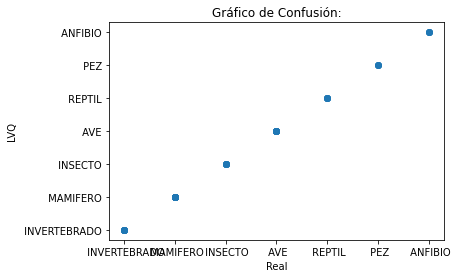

In [20]:
#@title Evaluar RNA LVQ usando datos de Entrenamiento

probarModeloLVQ(rnaLVQ, x_train, y_train, CLASES)


Real:  MAMIFERO / LVQ:  MAMIFERO (1): ok
Real:  PEZ / LVQ:  PEZ (4): ok
Real:  ANFIBIO / LVQ:  ANFIBIO (5): ok
Real:  INVERTEBRADO / LVQ:  INVERTEBRADO (7): ok
Real:  REPTIL / LVQ:  ANFIBIO (5): error!
Real:  INVERTEBRADO / LVQ:  INVERTEBRADO (7): ok
Real:  MAMIFERO / LVQ:  MAMIFERO (1): ok
Real:  AVE / LVQ:  AVE (2): ok
Real:  MAMIFERO / LVQ:  MAMIFERO (1): ok
Real:  INSECTO / LVQ:  INSECTO (6): ok

 Reporte de Clasificación: 
               precision    recall  f1-score   support

      ANFIBIO       0.50      1.00      0.67         1
          AVE       1.00      1.00      1.00         1
      INSECTO       1.00      1.00      1.00         1
 INVERTEBRADO       1.00      1.00      1.00         2
     MAMIFERO       1.00      1.00      1.00         3
          PEZ       1.00      1.00      1.00         1
       REPTIL       0.00      0.00      0.00         1

     accuracy                           0.90        10
    macro avg       0.79      0.86      0.81        10
 weighted avg   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


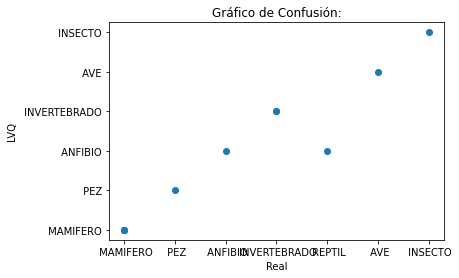

In [21]:
#@title Evaluar RNA LVQ usando datos de Prueba

probarModeloLVQ(rnaLVQ, x_test, y_test, CLASES)
